<h1 align='center'> <b> SKIN SCANNER CLASSIFICATION </b> </h1>

**Bộ dữ liệu:** [Dropbox](https://www.dropbox.com/scl/fi/aco2jcp6kkzij0v9f61dc/data.zip?rlkey=iak9wd4t96t3opo85lqeq7bfz&dl=0)

>[Data and libraries importing](#scrollTo=1OkkG4vTkdbo)

>[Data preparation](#scrollTo=VI_NIhnVkmUf)

>>[Data Module](#scrollTo=3JZ8-bGKycFz)

>[Model Training and Testing](#scrollTo=0tCTlXzokvGI)

>>[MobileNet V3 Large](#scrollTo=tGU1so-Ty1Gp)

>>[EfficientNet B3](#scrollTo=voYK7kTSdV_0)

>>[Ensemble Model](#scrollTo=Yxhy_cowvh1w)

>>>[Stacking method](#scrollTo=8LggRh7t1Dy_)

>[Model comparision](#scrollTo=LU-UyzXNHT5Z)

>[Evaluation](#scrollTo=6iFpL-9fk5Nj)

>[Conclusion](#scrollTo=7haIskM6ST7a)



#  1. Data and libraries importing

In [ ]:
!wget https://www.dropbox.com/scl/fi/aco2jcp6kkzij0v9f61dc/data.zip?rlkey=iak9wd4t96t3opo85lqeq7bfz&dl=0

--2024-01-06 14:17:18--  https://www.dropbox.com/scl/fi/aco2jcp6kkzij0v9f61dc/data.zip?rlkey=iak9wd4t96t3opo85lqeq7bfz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7449472b445410e91e88e88000.dl.dropboxusercontent.com/cd/0/inline/CK2PEFA7baPbkOAx1NSaudg5fkMZrJQaHRzMmoxVmR3TVKjMfDsrqN7yFIKqkqxSkZacP5GIRxHJbcCiINl9h2F6dRirANDTCP4tB9f4aTgvljqijmTKrAdIhoV8_LkWrm952wthCCQnCOdklcGnfziZ/file# [following]
--2024-01-06 14:17:19--  https://uc7449472b445410e91e88e88000.dl.dropboxusercontent.com/cd/0/inline/CK2PEFA7baPbkOAx1NSaudg5fkMZrJQaHRzMmoxVmR3TVKjMfDsrqN7yFIKqkqxSkZacP5GIRxHJbcCiINl9h2F6dRirANDTCP4tB9f4aTgvljqijmTKrAdIhoV8_LkWrm952wthCCQnCOdklcGnfziZ/file
Resolving uc7449472b445410e91e88e88000.dl.dropboxusercontent.com (uc7449472b445410e91e88e88000.dl.dropboxusercontent.com)... 162.125.80.15, 2620:10

In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 18.1 MB/s eta 0:00:00


In [ ]:
!unzip 'data.zip?rlkey=iak9wd4t96t3opo85lqeq7bfz'

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1348.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_250.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_2562.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_9789.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_4086.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_3030.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_4665.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1161.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_3931.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_804.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_204.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1533.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_1695.jpg  
  inflating: melanoma_cancer_dataset/train

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mlxtend.plotting import plot_confusion_matrix

import torch
from torch import nn
import torchmetrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from pathlib import Path

import torchvision
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from torchvision.io import read_image

import pytorch_lightning as L
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks import ModelSummary
from pytorch_lightning.loggers import CSVLogger

| Thư viện                                      | Giải thích                                                         |
| --------------------------------------------- | ------------------------------------------------------------------- |
| **os**                                        | Thư viện cho phép tương tác với hệ điều hành, quản lý thư mục và tệp tin. |
| **glob**                                      | Được sử dụng để tìm kiếm và tạo danh sách các tệp tin theo một mẫu trong thư mục. |
| **numpy**                                     | Thư viện toán học cung cấp các công cụ và hàm cho phép làm việc với mảng và ma trận số học. |
| **pandas**                                    | Thư viện cho phép làm việc với dữ liệu dạng bảng, giúp xử lý và phân tích dữ liệu dễ dàng hơn. |
| **matplotlib**                                | Thư viện cơ bản hỗ trợ cho matplotlib.pyplot để tạo và hiển thị biểu đồ, thường được sử dụng để trực quan hóa dữ liệu. |
| **mlxtend.plotting.plot_confusion_matrix**    | Thư viện mlxtend cung cấp một hàm để vẽ confusion matrix, thường được sử dụng trong việc đánh giá hiệu suất của mô hình học máy. |
| **torch**                                     | Thư viện core của PyTorch, được sử dụng cho việc xây dựng và huấn luyện mô hình học máy dựa trên mạng nơ-ron. |
| **torch.nn**                                  | Thư viện chứa các lớp và chức năng liên quan đến mạng nơ-ron trong PyTorch. |
| **torchmetrics**                              | Thư viện cung cấp các độ đo và số liệu thống kê để đánh giá hiệu suất của mô hình PyTorch. |
| **sklearn.metrics.accuracy_score**            | Hàm tính toán độ chính xác (accuracy) trong thư viện scikit-learn, được sử dụng để đánh giá hiệu suất mô hình phân loại. |
| **sklearn.model_selection.train_test_split**  | Hàm giúp chia dữ liệu thành các tập train và test trong việc huấn luyện mô hình. |
| **pathlib.Path**                              | Thư viện cho phép làm việc với đường dẫn và thư mục một cách dễ đọc và xử lý. |
| **torchvision**                              | Thư viện chứa các công cụ và datasets phổ biến để làm việc với hình ảnh trong PyTorch. |
| **efficientnet_b3**                          | Mô hình EfficientNet-B3 trong torchvision, một kiến trúc mạng nơ-ron sâu phổ biến cho việc xử lý hình ảnh. |
| **EfficientNet_B3_Weights**                  | Enum định danh trọng số cho mô hình EfficientNet-B3. |
| **WeightsEnum**                              | Enum định danh trọng số cho các mô hình torchvision khác nhau. |
| **torch.hub.load_state_dict_from_url**        | Hàm để tải trọng số mô hình từ một URL được chỉ định. |
| **v2**                                        | Một module trong torchvision.transforms để sử dụng phiên bản mới của các phép biến đổi hình ảnh. |
| **functional**                                | Một module trong torchvision.transforms để xử lý biến đổi hình ảnh theo các hàm. |
| **torchvision.transforms.functional**         | Một phiên bản khác của module trước đó trong torchvision, để xử lý biến đổi hình ảnh. |
| **torchvision.io.read_image**                | Hàm để đọc hình ảnh từ tệp tin hình ảnh. |
| **pytorch_lightning**                         | Thư viện giúp quản lý và huấn luyện mô hình PyTorch một cách dễ dàng và hiệu quả. |
| **pytorch_lightning.callbacks.ModelCheckpoint** | Callback cho PyTorch Lightning để lưu trọng số của mô hình trong quá trình huấn luyện. |
| **pytorch_lightning.callbacks.EarlyStopping** | Callback để dừng quá trình huấn luyện sớm nếu không có sự cải thiện đáng kể. |
| **lightning.pytorch.callbacks.ModelSummary**   | Custom callback để hiển thị tóm tắt của mô hình trong quá trình huấn luyện. |
| **pytorch_lightning.loggers.CSVLogger**       | Logger cho PyTorch Lightning để lưu thông tin huấn luyện vào các tệp CSV. |


# 2. Data preparation

In [ ]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

Hàm `plot`  được thiết kế để hiển thị hình ảnh và, nếu có, thông tin về các đối tượng trong hình ảnh (như bounding boxes và masks)
- Trước hết, nó kiểm tra xem phần tử đầu tiên của `imgs` có phải là một danh sách hay không?  Nếu `imgs` chỉ là một list của hình ảnh thay vì list của các list, nó sẽ chuyển `imgs` thành một list chứa một list duy nhất.
- Tiếp theo, nó tạo ra một lưới các subplots dựa trên số lượng hàng `num_rows` và số lượng cột `num_cols. `squeeze=False` đảm bảo rằng axs luôn là một mảng 2 chiều, ngay cả khi có một hàng hoặc một cột duy nhất.
- Trong vòng lặp lồng nhau, hàm xử lý từng hình ảnh và nếu cần, thông tin đối tượng tương ứng:
  - Kiểm tra xem mỗi img có phải là một tuple chứa hình ảnh và target (đối tượng) hay không.
  - Nếu có target, hàm tách chúng ra và kiểm tra xem target có phải là dict hay `tv_tensors.BoundingBoxes`. Nếu là dict, hàm lấy ra `boxes` và `masks`.
  - Hình ảnh được chuyển đổi thành định dạng có thể hiển thị (F.to_image), và chuẩn hóa hình ảnh nếu cần.
  - Nếu có thông tin về boxes hoặc masks, hàm vẽ chúng lên hình ảnh.
  - Cuối cùng, hình ảnh được hiển thị trong subplot tương ứng.
- Nếu row_title được cung cấp, hàm sẽ thêm tiêu đề cho mỗi hàng của lưới hình ảnh.
- `plt.tight_layout()` tự động điều chỉnh kích thước và vị trí của subplots sao cho chúng không chồng chéo lên nhau và được sắp xếp gọn gàng.

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)
img = read_image(str(Path('/content/melanoma_cancer_dataset/train/benign') / 'melanoma_4.jpg'))
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 300, 300])


- Thiết lập cấu hình Matplotlib:
  -  `plt.rcParams["savefig.bbox"]` cho phép cắt sát lề của các nội dung trong đồ họa, loại bỏ khoảng trống không cần thiết xung quanh.
  - `torch.manual_seed` giúp đảm bảo rằng các kết quả của các thao tác ngẫu nhiên trong PyTorch là nhất quán qua các lần chạy.
- Tiếp theo, đọc hình ảnh từ đường dẫn chỉ dẫn và lưu vào biến `img`, sau đó in ra thông tin về kiểu dữ liệu, kiểu dữ liệu của tensor và kích thước của hình ảnh.
- Kết quả: img là một tensor của PyTorch, mỗi pixel được biểu diễn ở một số nguyên không dấu 8-bit và là một hình ảnh màu RGB với chiều cao và chiều rộng 300 pixel.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


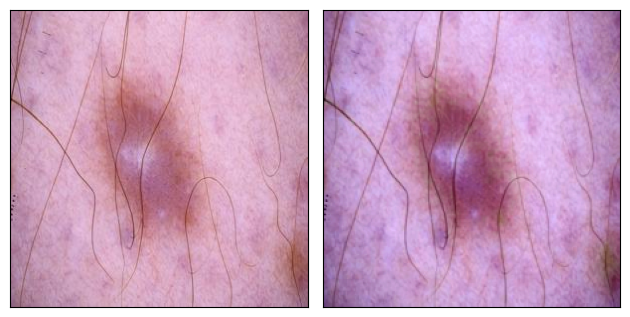

In [ ]:
transform = v2.Compose([v2.ToPILImage(),
                v2.Resize((224, 224)),
                v2.RandomHorizontalFlip(),
                v2.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.2, hue=0.1),
                v2.ToTensor(),
                v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
out = transform(img)

plot([img, out])

- Đầu tiên, sử dụng `v2.ToPILImage()`chuyển đổi tensor hình ảnh sang dạng hình ảnh PIL giúp việc hiển thị và xử lý dễ dàng hơn.
- `v2.Resize((224, 224))`thay đổi kích thước hình ảnh đầu vào thành 224x224 pixel.
- `v2.RandomHorizontalFlip()`áp dụng lật ngang hình ảnh một cách ngẫu nhiên, giúp tăng cường dữ liệu.
- `v2.ColorJitter(...)` thay đổi độ sáng, độ tương phản, độ bão hòa, và sắc độ của hình ảnh một cách ngẫu nhiên, cũng nhằm mục đích tăng cường dữ liệu.
- `v2.ToTensor()` chuyển hình ảnh PIL trở lại thành tensor PyTorch.
- Cuối cùng, `v2.Normalize(mean=[...], std=[...])` để thực hiện chuẩn hóa dữ liệu hình ảnh theo mean và std nhằm giúp cải thiện hiệu suất huấn luyện của mô hình.

In [ ]:
list_ = [name for name in os.listdir('/content/melanoma_cancer_dataset/train')]
list_.reverse()
NAME2NUMBER = {name: index for index, name in enumerate(list_)}
def get_path(tr_path):
    paths = []
    for root, dirs, files in os.walk(tr_path):
        for file in files:
            image_path = os.path.join(root, file)
            label = os.path.basename(os.path.dirname(image_path))
            paths.append({"path": image_path,
                          "label": NAME2NUMBER[label]
            })
    return paths

- Danh sách `list_` chứa tất cả các tên trong thư mục chỉ định và đảo ngược thứ tự của danh sách các thư mục.
- Dict `NAME2NUMBER` ánh xạ các tên thư mục từ `list_` thành một số nguyên bắt đầu từ 0. Cách này tạo ra một nhãn cho mỗi lớp.
- Hàm `get_path(tr_path)` sẽ tạo ra một danh sách, trong đó mỗi phần tử là một dict chứa đường dẫn của hình ảnh và nhãn số tương ứng, sẵn sàng để được sử dụng trong quá trình huấn luyện hoặc xác thực mô hình học máy.

In [ ]:
tr_df = get_path('/content/melanoma_cancer_dataset/train')

- Áp dụng hàm `get_path(tr_path)` để trả về danh sách các đối tượng dict, chứa thông tin về đường dẫn và nhãn của từng hình ảnh.

In [ ]:
class DataSet(torch.utils.data.Dataset):

  def __init__(self, features, transform=None):
    super(DataSet, self).__init__()
    self.features = features
    self.transform = transform

    # if calculate_stats:
    #         mean, std = self.calculate_mean_std()
  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    paths = self.features[idx]["path"]
    image = torchvision.io.read_image(paths) / 255.0
    #image = torch.stack([image[0], image[0], image[0]], 0)
    #image = v2.Grayscale()(image)

    if self.transform is not None:
      image = self.transform(image)

    label = torch.tensor(self.features[idx]["label"])
    return {"images": image,
            "labels": label}

Data = DataSet(tr_df)

Class `DataSet` kế thừa từ `torch.utils.data.Dataset` nhằm để xử lý dữ liệu cho việc huấn luyện mô hình:
- `__init__` là phương thức khởi tạo của lớp với 2 tham số chính:
  - `features`: một danh sách, nơi mỗi phần tử chứa thông tin về đường dẫn của hình ảnh và nhãn của nó.
  - `transform`: một chuỗi các biến đổi hình ảnh.
  - `self.features` và `self.transform` lưu trữ thông tin này để sử dụng trong các phương thức khác của lớp.
- `__len__` trả về số lượng phần tử trong `features`, cho biết kính thước của tập dữ liệu.
- `__getitem__` lấy một phần tử cụ thể từ dataset và bao gồm các bước:
  - Nó đọc hình ảnh từ đường dẫn `paths` và chuyển nó thành một tensor.
  - Hình ảnh được chia cho 255 để chuyển giá trị pixel về phạm vi [0, 1].
  - Nếu có biến đổi (transform), nó sẽ được áp dụng cho hình ảnh.
  - Trả về dictionary:
    - `images`: hình ảnh đã được xử lý.
    - `labels`: nhãn tương ứng hình ảnh.


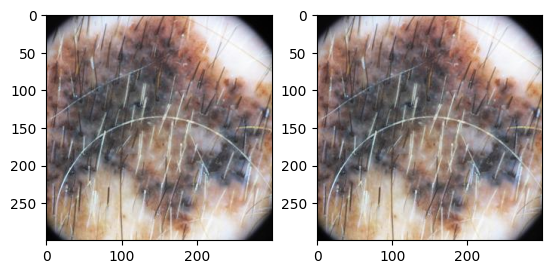

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

show([next(iter(Data))["images"], next(iter(Data))["images"]])

- Đầu tiên, kiểm tra xem `imgs` có phải là một list hay không. Nếu không, nó sẽ chuyển imgs thành một list.
- Tiếp theo, tạo subplót với số cột là số lượng hình ảnh trong `imgs`.
- Trong vòng lặp, mỗi tensor hình ảnh được `detach` (loại bỏ khỏi đồ thị tính toán, nếu cần) và chuyển đổi thành hình ảnh PIL để có thể hiển thị được.
- Sau đó, hiển thị mỗi hình ảnh PIL trên subplot tương ứng.

## Data Module

In [ ]:
class DataModule(L.LightningDataModule):
  def __init__(self, batch_size, num_workers, train_path, num_models = 1):
    super(DataModule, self).__init__()
    self.train_path = train_path
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.num_models = num_models
    self.train_transforms = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((224, 224)),
        v2.RandomHorizontalFlip(),
        v2.Grayscale(),
        v2.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.1, hue=0.2),
        v2.ToTensor(),
        v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    self.test_transforms = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((224, 224)),
        v2.Grayscale(),
        v2.ToTensor(),
        v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

  def setup(self, stage=None):
    train_paths = get_path(self.train_path)
    train_paths, temp_paths = train_test_split(train_paths, test_size=0.2, random_state = 0)
    val_paths, test_paths = train_test_split(temp_paths, test_size = 0.5, random_state = 0)
    if self.num_models == 1:
      self.train_dataset = DataSet(train_paths, transform=self.train_transforms)
    else:
      self.train_datasets = [DataSet(train_paths, transform=self.train_transforms) for _ in range(self.num_models)]
    self.val_dataset = DataSet(val_paths, transform = self.test_transforms)
    self.test_dataset = DataSet(test_paths, transform = self.test_transforms)

  def train_dataloader(self):
    if self.num_models != 1:
      train_loaders = [torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=self.batch_size,
                                    num_workers=self.num_workers) for dataset in self.train_datasets]
    else:
      train_loaders = torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                      batch_size=self.batch_size, num_workers=self.num_workers)
    return train_loaders

  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                      batch_size=self.batch_size, num_workers=self.num_workers)

Class `DataModule`, kế thừa từ `LightningModule` được sử dụng để quản lý và chuẩn bị dữ liệu cho quá trình huấn luyện:
  - `__init__`, phương thức khởi tạo nhận các tham số như:
    - batch_size: Kích thước của các batch dữ liệu được sử dụng trong quá trình huấn luyện và kiểm thử.
    - num_workers: Số lượng workers được sử dụng để tải dữ liệu song song.
    - train_path: Đường dẫn đến dữ liệu huấn luyện.
    - num_models: Số lượng mô hình (mặc định là 1).
    - Các tham số này được `self` lưu trữ để sử dụng trong các phương thức khác của lớp.
    - `super(DataModule, self).__init__()` gọi hàm khởi tạo của lớp cha (LightningDataModule) để khởi tạo các tính năng cơ bản của module Lightning.
    - `self.train_transforms` và `self.test_transforms` là các chuỗi biến đổi dữ liệu được xác định để áp dụng cho dữ liệu huấn luyện và kiểm thử.
      - `self.train_transforms` là các biến đổi cho tập huấn luyện bao gồm chuyển đổi hình ảnh sang định dạng PIL, thay đổi kích thước hình ảnh, lật ngang ngẫu nhiên, chuyển đổi thành ảnh đen trắng (grayscale), và các biến đổi màu sắc khác nhau  nhằm mục đích tăng cường dữ liệu huấn luyện.
      - `self.test_transforms` là các biến đổi cho tập kiểm thử bao gồm chuyển đổi hình ảnh sang định dạng PIL, thay đổi kích thước hình ảnh và chuyển đổi thành ảnh đen trắng (grayscale) mà không có tăng cường, để đảm bảo tính chính xác trong quá trình đánh giá mô hình.

- Phương thức `setup` được gọi để cài đặt và chuẩn bị các tập dữ liệu cần thiết
  - `train_paths`, `val_paths`, và `test_paths` được tạo ra từ `train_path` thông qua hàm `get_path` và `train_test_split`, phân chia dữ liệu thành tập huấn luyện, xác thực, và kiểm thử.
  -  Tùy thuộc vào `self.num_models`, phương thức tạo ra một hoặc nhiều tập dữ liệu huấn luyện.
  - `self.train_dataset`, `self.val_dataset`, và `self.test_dataset` được khởi tạo sử dụng lớp DataSet với các biến đổi tương ứng.
- Phương thức `train_dataloader`:
  - Phương thức này tạo và trả về DataLoader cho tập dữ liệu huấn luyện.
  - Nếu `self.num_models != 1`, nó tạo ra một danh sách các DataLoader, mỗi DataLoader tương ứng với một tập dữ liệu trong self.train_datasets. Nếu chỉ có một mô hình, phương thức trả về một DataLoader duy nhất cho `self.train_dataset`.
  - Các DataLoader sử dụng `shuffle=True` để xáo trộn dữ liệu, giúp quá trình huấn luyện đạt hiệu quả cao hơn.
- Phương thức `val_dataloader` và `test_dataloader`:
  - Hai phương thức này tạo và trả về DataLoader cho tập dữ liệu xác thực `val_dataset` và kiểm thử `test_dataset`.
 - Không sử dụng `shuffle` cho dữ liệu xác thực và kiểm thử, để đảm bảo kết quả đánh giá là nhất quán.

In [ ]:
train_path = '/content/melanoma_cancer_dataset/train'

# 3. Model Training and Testing

## MobileNet V3 Large

In [ ]:
class Mobilenet_V3(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
    super(Mobilenet_V3, self).__init__()
    backbone = torchvision.models.mobilenet_v3_large(pretrained = True)
    num_filters = 960
    layers = list(backbone.children())[:-1]
    self.feature_extractor = torch.nn.Sequential(*layers)
    # self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.classifier = nn.Sequential(
            nn.Linear(num_filters, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, num_target_classes)
        )
    self.is_train = is_train
    self.learning_rate = learning_rate
    self.loss = torch.nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_target_classes)

  def forward(self, x):
    #self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["images"]
    y = batch["labels"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)
    acc = self.accuracy(y_pred, y)
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["images"]
    y = batch["labels"]
    self.eval()
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)
    val_acc = self.accuracy(y_pred, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["images"]
    y = batch["labels"]
    self.eval()
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)
    test_acc = self.accuracy(y_pred, y)
    self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
    x = batch["images"]
    y = batch["labels"]
    self.eval()
    with torch.no_grad():
      y_pred = self(x)
      y_pred = torch.nn.functional.softmax(y_pred, dim=-1)
    predicted_label = torch.argmax(y_pred, dim=1)
    pre_acc = self.accuracy(y, predicted_label)
    return {'True label': y, 'Predict label':predicted_label, 'Accuracy': pre_acc}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

`MobileNetV3` là phiên bản cải tiến của hai mô hình `MobileNetV2` và `MobileNetV1`.

class `Mobilenet_V3` kế thừa từ `LightningModule` từ PyTorch Lightning:
  - `__init__` phương thức khởi tạo nhận các tham số như:
      - `is_train` xác định mô hình đang trong quá trình huấn luyện hay không.
      - `learning_rate` tốc độ học trong quá trình tối ưu hóa mô hình.
      - `num_target_classes` số lượng lớp mục tiêu mà mô hình sẽ phân loại.
      - Các tham số này được `self` lưu trữ để sử dụng trong các phương thức khác của lớp.
      - `super(Mobilenet_V3, self).__init__()` gọi hàm khởi tạo của lớp cha (LightningModule) để khởi tạo các tính năng cơ bản của module Lightning.
      - Feature Extractor:
        - `backbone = torchvision.models.mobilenet_v3_large(pretrained=True)` cho phép tạo một mô hình sử dụng kiến trúc MobileNetV3 lớn với trọng số đã được huấn luyện trước. Đây chính là kiến trúc mạng neural được sử dụng để trích xuất đặc trưng (feature extraction) từ hình ảnh.
        - `layers = list(backbone.children())[:-1]` lấy tất cả các layer của mạng MobileNetV3 trừ layer cuối cùng. Layer cuối cùng không được sử dụng vì nó liên quan đến phần phân loại của mạng gốc.
        - `self.feature_extractor = torch.nn.Sequential(*layers)` chứa phần lớn của mô hình MobileNetV3, giữa lại khả năng trích xuất đặc  trưng hình ảnh mạnh mẽ của nó.
      - Classifier:
        - `num_filters = 960` số lượng filters của lớp cuối cùng trong MobileNetV3, sau khi trích xuất đặc trưng từ mạng.
        - `self.classifier` bao gồm một chuỗi các lớp tuyến tính `nn.Linear`, một hàm kích hoạt `nn.ReLU` và một lớp `nn.Drôput` để giảm hiện tượng overfitting.
        -  Lớp cuối cùng chuyển số lượng filters thành số lượng lớp mục tiêu `num_target_classes` bằng cách sử dụng lớp fully connected, cho phép mô hình phân loại dữ liệu đầu vào thành các lớp tương ứng.
      - `self.loss = torch.nn.CrossEntropyLoss()` xác định hàm mất mát CrossEntropyLoss để đánh giá mất mát của mô hình trong quá trình huấn luyện.
      - `self.accuracy` sử dụng `torchmetrics `để theo dõi độ chính xác (accuracy) của mô hình trên tập dữ liệu giúp ích trong việc đánh giá hiệu suất mô hình trong quá trình huấn luyện và xác thực.

- Phương thức `forward`:
  - Đây là phương thức chính xác định cách dữ liệu đi qua mô hình (x là đầu vào).
  - Dữ liệu đầu vào qua `self.feature_extractor` để trích xuất đặc trưng, `flatten(1)` làm phẳng tensor đầu ra để phù hợp với kích thước ban đầu của lớp phân loại.
  -  Khi huấn luyện `self.is_train`, dữ liệu đi qua bình thường. Khi không huấn luyện, `torch.no_grad()` được sử dụng để vô hiệu hóa việc tính toán gradient, giảm bớt tài nguyên tính toán.
  - Cuối cùng, đầu ra của `self.feature_extractor` được đưa vào `self.classifier` để phân loại.

- Phương thức `training_step`:
  - Phương thức này xác định cách mô hình được huấn luyện trên mỗi batch dữ liệu.
  - `y_pred` là dự đoán của mô hình từ dữ liệu đầu vào x.
  - `loss` được tính toán dựa trên hàm mất mát `self.loss` và so sánh dự đoán `y_pred` với nhãn thực tế `y`.
  - Độ chính xác `acc` cũng được tính toán.
  - Kết quả là mất mát `loss` được trả về, và cả mất mát lẫn độ chính xác được ghi nhận.

- Phương thức `validation_step`:
  - Tương tự như `training_step`, nhưng dành cho quá trình xác thực.
  - Sử dụng `self.eval()` để chuyển mô hình sang chế độ xác thực, tắt certain PyTorch features như `Dropout`.
  - Tính mất mát và độ chính xác trên dữ liệu xác thực.

- Phương thức `test_step`:
  - Dùng để đánh giá mô hình trên tập kiểm thử.
  - Tương tự như `validation_step`, nhưng kết quả là mất mát và độ chính xác trên tập kiểm thử.

- Phương thức `predict_step`:
  - Dùng để dự đoán nhãn từ dữ liệu đầu vào.
  - Sử dụng `self.eval()` để chuyển mô hình sang chế độ đánh giá. Trong chế độ này, mô hình sẽ vô hiệu hóa các tính năng chỉ sử dụng trong quá trình huấn luyện, như `Dropout`. Điều này giúp đảm bảo rằng mô hình dự đoán một cách ổn định và nhất quán.
  - `with torch.no_grad()` đảm bảo rằng không có gradient nào được tính toán trong quá trình này, giúp tiết kiệm tài nguyên tính toán.
    - `y_pred = self(x)` sử dụng phương thức forward của mô hình để lấy dự đoán từ dữ liệu hình ảnh.
    - `torch.nn.functional.softmax(y_pred, dim=-1)` áp dụng hàm softmax lên đầu ra để chuyển chúng thành các xác suất.
  - Dự đoán nhãn (chọn chỉ số của lớp có xác suất cao nhất từ đầu ra softmax) và so sánh với nhãn thực tế để đánh giá độ chính xác của dự đoán.

- Phương thức `configure_optimizers`:
  - Định nghĩa optimizer - Adam với tốc độ học được xác định trong `self.learning_rate` cho quá trình huấn luyện.
  - Optimizer là thành phần quan trọng quyết định cách thức cập nhật trọng số mạng trong quá trình huấn luyện.

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1,
                                   filename='mobilenet_{epoch}-{acc:02.0f}'
                                    )
logger = CSVLogger(save_dir="logs/", name="mobilenet")
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

mobilenet = Mobilenet_V3(is_train = True)
data_module = DataModule(64, 1, train_path)

trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks,logger=logger)
trainer.fit(mobilenet, data_module)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will sign

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 133: 'val_acc' reached 0.89340 (best 0.89340), saving model to '/content/checkpoint/mobilenet_epoch=0-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 133: 'val_acc' reached 0.89340 (best 0.89340), saving model to '/content/checkpoint/mobilenet_epoch=0-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 266: 'val_acc' reached 0.92075 (best 0.92075), saving model to '/content/checkpoint/mobilenet_epoch=1-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 266: 'val_acc' reached 0.92075 (best 0.92075), saving model to '/content/checkpoint/mobilenet_epoch=1-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 399: 'val_acc' reached 0.93019 (best 0.93019), saving model to '/content/checkpoint/mobilenet_epoch=2-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 399: 'val_acc' reached 0.93019 (best 0.93019), saving model to '/content/checkpoint/mobilenet_epoch=2-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 532: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 532: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 665: 'val_acc' reached 0.93396 (best 0.93396), saving model to '/content/checkpoint/mobilenet_epoch=4-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 665: 'val_acc' reached 0.93396 (best 0.93396), saving model to '/content/checkpoint/mobilenet_epoch=4-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 798: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 798: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 931: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 931: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1064: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1064: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1197: 'val_acc' reached 0.93868 (best 0.93868), saving model to '/content/checkpoint/mobilenet_epoch=8-acc=00-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1197: 'val_acc' reached 0.93868 (best 0.93868), saving model to '/content/checkpoint/mobilenet_epoch=8-acc=00-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 1330: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 1330: 'val_acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Thiết lập Callbacks và Logger:
- **ModelCheckpoint** dùng để lưu mô hình trong quá trình huấn luyện:
  - `dirpath='checkpoint/'` xác định thư mục lưu checkpoint.
  - `monitor="val_acc"` chỉ định rằng checkpoint sẽ được lưu dựa trên độ chính xác trên tập xác thực `val_acc`.
  - `mode="max"` để lưu checkpoint với độ chính xác cao nhất.
  - `save_top_k=1` chỉ giữ lại 1 checkpoint tốt nhất.
  - `filename='mobilenet_{epoch}-{acc:02.0f}'` định dạng tên file cho checkpoint.

- **CSVLogger** dùng để ghi lại thông tin huấn luyện vào file CSV:
  - `save_dir="logs/"` xác định thư mục lưu log.
  - `name="mobilenet"` đặt tên cho file log.

- **EarlyStopping** dùng để dừng sớm quá trình huấn luyện nếu không có tiến triển.
  - `monitor="val_acc"` và `mode="max"` có nghĩa là quá trình sẽ dừng nếu độ chính xác trên tập xác thực không tăng.
  - `min_delta=1e-4` và `patience=5` đặt ngưỡng thay đổi tối thiểu và số lượng epochs chờ đợi trước khi dừng.

Khởi tạo mô hình và module dữ liệu:
- `mobilenet = Mobilenet_V3(is_train=True)` tạo một thực thể của mô hình Mobilenet_V3 ở chế độ huấn luyện.
- `data_module = DataModule(64, 1, train_path)` tạo một thực thể của DataModule với batch size là 64, một worker và đường dẫn đến tập dữ liệu huấn luyện.

Huấn luyện mô hình: L.Trainer là trình huấn luyện của PyTorch Lightning, cung cấp nhiều chức năng tiện ích.
- `max_epochs=10` đặt số lượng epochs tối đa là 10.
- `detect_anomaly=True` giúp phát hiện các vấn đề trong quá trình lan truyền ngược (backpropagation).
- `callbacks` và `logger` áp dụng các callbacks và logger đã được thiết lập trước đó.
- Cuối cùng, `trainer.fit(mobilenet, data_module)` bắt đầu quá trình huấn luyện mô hình `mobilenet` sử dụng dữ liệu từ `data_module`.

**Kết quả huấn luyện:**
- Quá trình huấn luyện trải qua `9 epochs` và mô hình đạt được độ chính xác cao nhất là `0.93868` ở `epoch thứ 8`.
- Điều này cho thấy mô hình có khả năng học tốt từ dữ liệu và đạt được kết quả tốt trên tập xác thực.
- Tuy nhiên, sau epoch thứ 8, không có sự cải thiện nào trong độ chính xác xác thực `val_acc` đáng kể để lưu thêm checkpoint. Điều này cho thấy rằng mô hình đã đạt đến mức độ hội tụ nhất định.

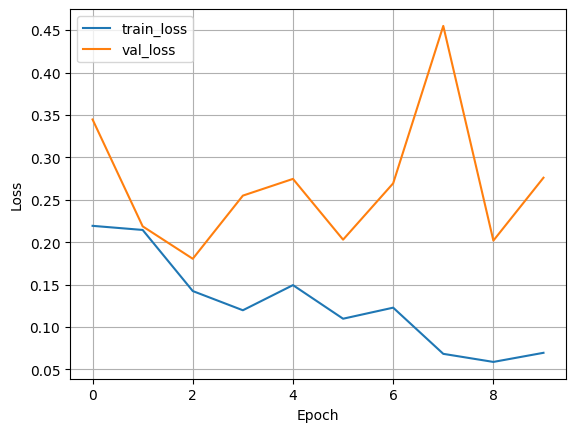

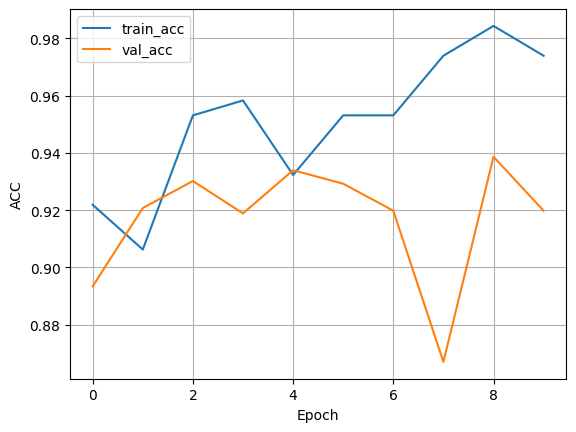

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

- Đọc dữ liệu  về quá trình huấn luyện mô hình được lưu trong file `metrics.csv`.
- Dữ liệu được nhóm theo cột epoch (mỗi epoch đại diện cho một lần lặp qua toàn bộ tập dữ liệu huấn luyện).
- Với mỗi nhóm (tức là mỗi epoch), tính giá trị trung bình `mean` cho tất cả các cột, đây có thể là các giá trị như mất mát và độ chính xác cho tập huấn luyện và xác thực.
- Kết quả tổng hợp được lưu vào danh sách `aggreg_metrics`, sau đó được tổng hợp được chuyển thành một DataFrame mới `df_metrics`.
---
**Loss visualization**:
- Dữ liệu về mất mát trong quá trình huấn luyện `train_loss` và xác thực `val_loss` được trực quan hóa.
- Trục `x` biểu diễn số lượng `epoch`, trong khi trục `y` biểu diễn giá trị mất mát `loss`.
- `grid=True` và `legend=True` giúp làm rõ biểu đồ.

**Accuracy visualization**:
- Tương tự, dữ liệu về độ chính xác trong quá trình huấn luyện `train_acc` và xác thực `val_acc` được trực quan hóa.
- Biểu đồ này giúp theo dõi sự thay đổi của độ chính xác qua mỗi epoch.
---
**Nhận xét kết quả**:
- Biểu đồ cho thấy `train_loss` giảm đáng kể sau epoch đầu tiên và tiếp tục duy trì một xu hướng giảm nhẹ qua các epoch tiếp theo. Bên cạnh đó, `val_loss` dù biến động nhẹ nhưng xu hướng giảm dần. Tuy nhiên, độ chênh lệch giữa `train_loss` và `val_loss` không lớn, cho thấy mô hình không bị overfitting.
- Biểu đồ `train_acc` tăng lên và duy trì ở mức cao qua các epoch cho thấy mô hình có hiệu suất tốt và ổn định. Tuy có sự biến động về `val_acc` nhẹ nhưng tổng quan chung thì `val_acc` tăng dần. Nói chung, mô hình duy trì một hiệu suất cao và độ chính xác tốt trên cả hai tập dữ liệu qua các epoch.

In [ ]:
trainer.test(model=mobilenet, datamodule=data_module, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /content/checkpoint/mobilenet_epoch=8-acc=00-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoint/mobilenet_epoch=8-acc=00-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/checkpoint/mobilenet_epoch=8-acc=00-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoint/mobilenet_epoch=8-acc=00-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9283694624900818     │
│         test_loss         │    0.22913803160190582    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22913803160190582, 'test_acc': 0.9283694624900818}]

- Kết quả kiểm thử mô hình `Mobilenet` cho thấy hiệu suất rất tốt trên tập dữ liệu kiểm thử với độ chính xác khoảng **92.84%** và mất mát là **0.229**. Điều này chỉ ra rằng mô hình đã được khôi phục từ `checkpoint` tốt nhất và đã giữ được hiệu suất khi áp dụng trên dữ liệu chưa từng thấy trước đó.

## EfficientNet B3

In [ ]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
efficientnet_b3(weights="DEFAULT")

- Hàm `get_state_dict` thay thế cho hành vi mặc định:
  - kwargs.pop("check_hash") loại bỏ khỏi từ điển kwargs mục nhập có khóa "check_hash" nếu có. Điều này có thể làm để tránh việc kiểm tra hash của trọng số, có thể cần thiết nếu bạn biết trước rằng hash không khớp nhưng vẫn muốn tải trọng số.
  - Trả về `load_state_dict_from_url(self.url, *args, **kwargs)` một hàm của PyTorch để tải trạng thái của mô hình (là một dictionary chứa trọng số của mô hình) từ một URL xác định.

- Cập nhật phương thức `get_state_dict` cho lớp hoặc `enum WeightsEnum`, có thể được sử dụng để quản lý các phiên bản trọng số của mô hình.

- `EfficientNet_B3_Weights.IMAGENET1K_V1` sử dụng trọng số từ một phiên bản cụ thể được định nghĩa trong enum `EfficientNet_B3_Weights`, đã được định nghĩa trước là một tập trọng số cụ thể từ việc huấn luyện trên tập dữ liệu ImageNet.

- `weights="DEFAULT"` sử dụng giá trị mặc định cho trọng số.

In [ ]:
class Efficientnet_B3(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=2):
    super(Efficientnet_B3, self).__init__()
    backbone = efficientnet_b3(pretrained = True)
    num_filters = 1536
    layers = list(backbone.children())[:-1]
    self.feature_extractor = torch.nn.Sequential(*layers)
    # self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.classifier = nn.Sequential(
            nn.Linear(num_filters, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, num_target_classes)
        )
    self.is_train = is_train
    self.learning_rate = learning_rate
    self.loss = torch.nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_target_classes)

  def forward(self, x):
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x = batch["images"]
    y = batch["labels"]
    y_pred = self(x)
    loss = self.loss(y_pred, y)
    acc = self.accuracy(y_pred, y)
    self.log_dict({'train_loss': loss, 'train_acc': acc} , prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x = batch["images"]
    y = batch["labels"]
    self.eval()
    y_pred = self(x)
    val_loss = self.loss(y_pred, y)
    val_acc = self.accuracy(y_pred, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x = batch["images"]
    y = batch["labels"]
    self.eval()
    y_pred = self(x)
    test_loss = self.loss(y_pred, y)
    test_acc = self.accuracy(y_pred, y)
    self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
    x = batch["images"]
    y = batch["labels"]
    self.eval()
    with torch.no_grad():
      y_pred = self(x)
      y_pred = torch.nn.functional.softmax(y_pred, dim=-1)
    predicted_label = torch.argmax(y_pred, dim=1)
    pre_acc = self.accuracy(y, predicted_label)
    return {'True label': y, 'Predict label':predicted_label, 'Accuracy': pre_acc}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

`EfficientNet B3` là một mô hình học sâu hiệu quả cung cấp sự cân bằng tối ưu giữa độ chính xác và kích thước mô hình, được huấn luyện sẵn trên tập dữ liệu `ImageNet`.

class `Efficientnet_B3` kế thừa từ `LightningModule` từ PyTorch Lightning:
  - `__init__` phương thức khởi tạo nhận các tham số như:
      - `is_train` xác định mô hình đang trong quá trình huấn luyện hay không.
      - `learning_rate` tốc độ học trong quá trình tối ưu hóa mô hình.
      - `num_target_classes` số lượng lớp mục tiêu mà mô hình sẽ phân loại.
      - Các tham số này được `self` lưu trữ để sử dụng trong các phương thức khác của lớp.
      - `super(Efficientnet_B3, self).__init__()` gọi hàm khởi tạo của lớp cha (LightningModule) để khởi tạo các tính năng cơ bản của module Lightning.
      - Feature Extractor:
        - `efficientnet_b3(pretrained=True)` để tạo mô hình với trọng số đã được huấn luyện trước từ ImageNet, cung cấp khả năng trích xuất đặc trưng mạnh mẽ.
        - `layers = list(backbone.children())[:-1]` lấy tất cả các layer của mạng EfficientnetB3 trừ layer cuối cùng. Layer cuối cùng không được sử dụng vì nó liên quan đến phần phân loại của mạng gốc.
        - `self.feature_extractor = torch.nn.Sequential(*layers)` chứa phần lớn của mô hình EfficientnetB3, giữa lại khả năng trích xuất đặc  trưng hình ảnh mạnh mẽ của nó.
      - Classifier:
        - `num_filters = 1536` số lượng filters của lớp cuối cùng trong EfficientnetB3, sau khi trích xuất đặc trưng từ mạng.
        - `self.classifier` bao gồm một chuỗi các lớp tuyến tính `nn.Linear`, một hàm kích hoạt `nn.ReLU` và một lớp `nn.Drôput` để giảm hiện tượng overfitting.
        -  Lớp cuối cùng chuyển số lượng filters thành số lượng lớp mục tiêu `num_target_classes` bằng cách sử dụng lớp fully connected, cho phép mô hình phân loại dữ liệu đầu vào thành các lớp tương ứng.
      - `self.loss = torch.nn.CrossEntropyLoss()` xác định hàm mất mát CrossEntropyLoss để đánh giá mất mát của mô hình trong quá trình huấn luyện.
      - `self.accuracy` sử dụng `torchmetrics `để theo dõi độ chính xác (accuracy) của mô hình trên tập dữ liệu giúp ích trong việc đánh giá hiệu suất mô hình trong quá trình huấn luyện và xác thực.

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1,
                                   filename='efficientnet_b3_{epoch}-{acc:02.0f}'
                                   )
logger = CSVLogger(save_dir="logs/", name="efficientnet_b3")
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]

efficientnet = Efficientnet_B3(is_train = True)
data_module = DataModule(64, 2, train_path)

trainer = L.Trainer(max_epochs=10, detect_anomaly=True, callbacks=callbacks,logger=logger)
trainer.fit(efficientnet, data_module)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significan

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 133: 'val_acc' reached 0.92736 (best 0.92736), saving model to '/content/checkpoint/efficientnet_b3_epoch=0-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 133: 'val_acc' reached 0.92736 (best 0.92736), saving model to '/content/checkpoint/efficientnet_b3_epoch=0-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 266: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 266: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 399: 'val_acc' reached 0.93396 (best 0.93396), saving model to '/content/checkpoint/efficientnet_b3_epoch=2-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 399: 'val_acc' reached 0.93396 (best 0.93396), saving model to '/content/checkpoint/efficientnet_b3_epoch=2-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 532: 'val_acc' reached 0.94057 (best 0.94057), saving model to '/content/checkpoint/efficientnet_b3_epoch=3-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 532: 'val_acc' reached 0.94057 (best 0.94057), saving model to '/content/checkpoint/efficientnet_b3_epoch=3-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 665: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 665: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 798: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 798: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 931: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 931: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 1064: 'val_acc' reached 0.94340 (best 0.94340), saving model to '/content/checkpoint/efficientnet_b3_epoch=7-acc=00.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 1064: 'val_acc' reached 0.94340 (best 0.94340), saving model to '/content/checkpoint/efficientnet_b3_epoch=7-acc=00.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 1197: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 1197: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 1330: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 1330: 'val_acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Thiết lập Callbacks và Logger:
- **ModelCheckpoint** dùng để lưu mô hình trong quá trình huấn luyện:
  - `dirpath='checkpoint/'` xác định thư mục lưu checkpoint.
  - `monitor="val_acc"` chỉ định rằng checkpoint sẽ được lưu dựa trên độ chính xác trên tập xác thực `val_acc`.
  - `mode="max"` để lưu checkpoint với độ chính xác cao nhất.
  - `save_top_k=1` chỉ giữ lại 1 checkpoint tốt nhất.
  - `filename='efficientnet_b3_{epoch}-{acc:02.0f}'` định dạng tên file cho checkpoint.

- **CSVLogger** dùng để ghi lại thông tin huấn luyện vào file CSV:
  - `save_dir="logs/"` xác định thư mục lưu log.
  - `name="efficientnet_b3"` đặt tên cho file log.

- **EarlyStopping** dùng để dừng sớm quá trình huấn luyện nếu không có tiến triển.
  - `monitor="val_acc"` và `mode="max"` có nghĩa là quá trình sẽ dừng nếu độ chính xác trên tập xác thực không tăng.
  - `min_delta=1e-4` và `patience=5` đặt ngưỡng thay đổi tối thiểu và số lượng epochs chờ đợi trước khi dừng.

Khởi tạo mô hình và module dữ liệu:
- `efficientnet = Efficientnet_B3(is_train = True)` tạo một thực thể của mô hình EfficientNet_B3 ở chế độ huấn luyện.
- `data_module = DataModule(64, 2, train_path)` tạo một thực thể của DataModule với batch size là 64, hai worker và đường dẫn đến tập dữ liệu huấn luyện.

Huấn luyện mô hình: L.Trainer là trình huấn luyện của PyTorch Lightning, cung cấp nhiều chức năng tiện ích.
- `max_epochs=10` đặt số lượng epochs tối đa là 10.
- `detect_anomaly=True` giúp phát hiện các vấn đề trong quá trình lan truyền ngược (backpropagation).
- `callbacks` và `logger` áp dụng các callbacks và logger đã được thiết lập trước đó.
- Cuối cùng, `trainer.fit(efficientnet, data_module)` bắt đầu quá trình huấn luyện mô hình `efficientnet` sử dụng dữ liệu từ `data_module`.

**Kết quả huấn luyện**:
- Quá trình huấn luyện mô hình EfficientNet B3 đã được thực hiện qua `10 epochs`.
- Độ chính xác xác thực (val_acc) tốt nhất được ghi nhận là `0.94340` tại `epoch thứ 7`, với checkpoint tương ứng được lưu lại.
- Tổng số tham số có thể huấn luyện là 13.8 triệu, cho thấy mô hình khá lớn và có thể mô tả dữ liệu một cách chi tiết.
- Tuy nhiên, không có cải thiện đáng kể về độ chính xác xác thực sau epoch thứ 7, dẫn đến việc không có thêm checkpoint nào được lưu. Điều này có thể chỉ ra rằng mô hình đã đạt đến ngưỡng hội tụ trên dữ liệu xác thực mà không còn cải thiện thêm.

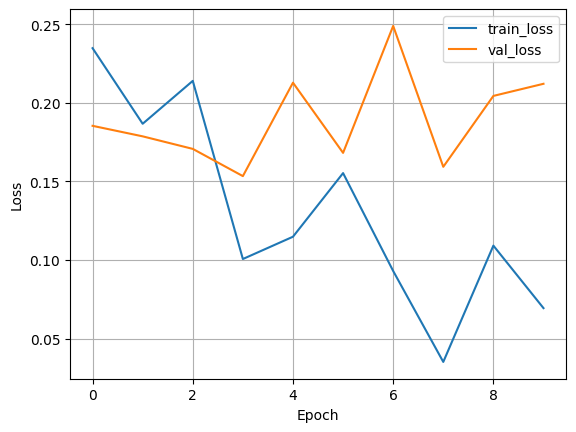

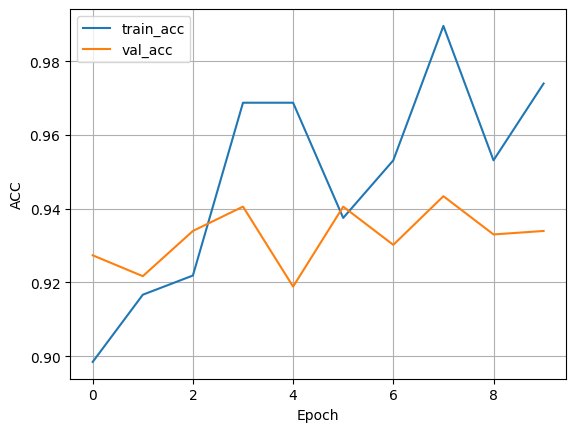

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

- Đọc dữ liệu  về quá trình huấn luyện mô hình được lưu trong file `metrics.csv`.
- Dữ liệu được nhóm theo cột epoch (mỗi epoch đại diện cho một lần lặp qua toàn bộ tập dữ liệu huấn luyện).
- Với mỗi nhóm (tức là mỗi epoch), tính giá trị trung bình `mean` cho tất cả các cột, đây có thể là các giá trị như mất mát và độ chính xác cho tập huấn luyện và xác thực.
- Kết quả tổng hợp được lưu vào danh sách `aggreg_metrics`, sau đó được tổng hợp được chuyển thành một DataFrame mới `df_metrics`.
---
**Loss visualization**:
- Dữ liệu về mất mát trong quá trình huấn luyện `train_loss` và xác thực `val_loss` được trực quan hóa.
- Trục `x` biểu diễn số lượng `epoch`, trong khi trục `y` biểu diễn giá trị mất mát `loss`.
- `grid=True` và `legend=True` giúp làm rõ biểu đồ.

**Accuracy visualization**:
- Tương tự, dữ liệu về độ chính xác trong quá trình huấn luyện `train_acc` và xác thực `val_acc` được trực quan hóa.
- Biểu đồ này giúp theo dõi sự thay đổi của độ chính xác qua mỗi epoch.
---
**Nhận xét kết quả**:
- Biểu đồ cho thấy `train_loss` của mô hình EfficientNet B3 giảm và có xu hướng ổn định qua các epoch, trong khi đó `val_loss` biểu hiện sự ổn định và có xu hướng tăng lên. Điều này cho thấy mô hình có sự ổn định tương đối về mất mát qua các epoch, và sự biến động có thể không đáng kể trong bối cảnh thực tế. Ngoài ra, độ chênh lệch giữa `train_loss` và `val_loss` không lớn, cho thấy mô hình không bị overfitting.
- Biểu đồ `acc` qua các epoch cho thấy cả hai biểu đồ đều có sự biến động, nhưng hiệu suất tổng thể của mô hình vẫn rất cao. Sự biến động nhẹ trong `val_loss` và `val_acc` có thể chỉ là phản ánh của sự đa dạng trong dữ liệu thực tế mà mô hình phải đối mặt. Tóm lại, điều này cho thấy mô hình `EfficientNet B3` có khả năng học tốt từ dữ liệu và tổng quát hóa khá tốt trên dữ liệu chưa thấy.

In [ ]:
trainer.test(model=efficientnet_b3, datamodule=data_module, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /content/checkpoint/efficientnet_b3_epoch=5-acc=00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoint/efficientnet_b3_epoch=5-acc=00.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/checkpoint/efficientnet_b3_epoch=5-acc=00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoint/efficientnet_b3_epoch=5-acc=00.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9406220316886902     │
│         test_loss         │    0.19610129296779633    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19610129296779633, 'test_acc': 0.9406220316886902}]

- Kết quả kiểm thử mô hình `EfficientNet B3` sau khi khôi phục từ `checkpoint` cho thấy hiệu suất tốt trên tập dữ liệu kiểm thử với độ chính xác khoảng **94.06%** và mất mát là khoảng **0.196**. Điều này ngụ ý mô hình đã học hiệu quả từ dữ liệu huấn luyện và khả năng tổng quát hóa tốt trên dữ liệu mới.

## Ensemble Model

### Stacking method

Mô hình `ensemble` là kỹ thuật kết hợp nhiều mô hình học máy để tạo ra một mô hình cuối cùng với hiệu suất tốt hơn so với từng mô hình đơn lẻ. Ở đây, mô hình `ensemble` sử dụng nhiều thể hiện của mô hình `Mobilenet_V3`.

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1,
                                   filename='mobilenet_ensemble_{epoch}-{acc:02.0f}'
                                   )
logger = CSVLogger(save_dir="logs/", name="ensemble_model")
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping]
num_models = 5
ensemble_model = [Mobilenet_V3(is_train = True) for _ in range(num_models)]
data_module = DataModule(64, 2, train_path, num_models)
data_module.setup()
for model_idx, (model, train_loader) in enumerate(zip(ensemble_model, data_module.train_dataloader())):
    trainer = L.Trainer(max_epochs=10)
    trainer.fit(model, train_loader, data_module.val_dataloader())

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 3.0 M 
1 | classifier        | Sequential         | 2.0 M 
2 | loss              | CrossEntropyLoss   | 0     
3 | accuracy          | MulticlassAccuracy | 0     
---------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 3.0 M 
1 | classifier        | Sequential         | 2.0 M 
2 | loss  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 3.0 M 
1 | classifier        | Sequential         | 2.0 M 
2 | loss  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 3.0 M 
1 | classifier        | Sequential         | 2.0 M 
2 | loss  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 3.0 M 
1 | classifier        | Sequential         | 2.0 M 
2 | loss  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Thiết lập Callbacks và Logger:
- **ModelCheckpoint** dùng để lưu mô hình trong quá trình huấn luyện:
  - `dirpath='checkpoint/'` xác định thư mục lưu checkpoint.
  - `monitor="val_acc"` chỉ định rằng checkpoint sẽ được lưu dựa trên độ chính xác trên tập xác thực val_acc.
  - `mode="max"` để lưu checkpoint với độ chính xác cao nhất.
  - `save_top_k=1` chỉ giữ lại 1 checkpoint tốt nhất.
  - `filename='mobilenet_ensemble_{epoch}-{acc:02.0f}'` định dạng tên file cho checkpoint.
- **CSVLogger** dùng để ghi lại thông tin huấn luyện vào file CSV:
  - `save_dir="logs/"` xác định thư mục lưu log.
  - `name="ensemble_model"` đặt tên cho file log.
- **EarlyStopping** dùng để dừng sớm quá trình huấn luyện nếu không có tiến triển.
  - `monitor="val_acc"` và `mode="max"` có nghĩa là quá trình sẽ dừng nếu độ chính xác trên tập xác thực không tăng.
  - `min_delta=1e-4` và `patience=5` đặt ngưỡng thay đổi tối thiểu và số lượng epochs chờ đợi trước khi dừng.

Khởi tạo mô hình và module dữ liệu:
  - `num_models = 5` có nghĩa 5 mô hình Mobilenet_V3 sẽ được tạo và huấn luyện độc lập với nhau.
  - `ensemble_model` tạo một list các `ensemble_model` chứa 5 mô hình `Mobilenet_V3`, mỗi mô hình được khởi tạo để huấn luyện với tham số `is_train = True`.
  - `DataModule(64, 2, train_path, num_models)` lớp này chuẩn bị dữ liệu cho quá trình huấn luyện và xác thực. Nó được khởi tạo với kích thước batch là 64, 2 workers, đường dẫn đến dữ liệu huấn luyện `train_path` và số lượng mô hình trong ensemble (num_models).
  - `data_module.setup()` phương thức này được gọi để thiết lập và chuẩn bị dữ liệu cho việc huấn luyện và xác thực.

Huấn luyện từng mô hình:
  - Vòng lặp for duyệt qua mỗi mô hình trong `ensemble_model` và mỗi `DataLoader` tương ứng từ `data_module.train_dataloader()`, nơi `train_loader` là `DataLoader` cung cấp dữ liệu huấn luyện cho mỗi mô hình.
  - `L.Trainer` khởi tạo trình huấn luyện của PyTorch Lightning với số lượng epochs tối đa là 10.
  - `trainer.fit()` Phương thức này bắt đầu quá trình huấn luyện mô hình với tập huấn luyện từ `train_loader` và tập xác thực từ `data_module.val_dataloader()`.

In [ ]:
# Predict with the ensemble
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()

ensemble_predictions = []

for model_idx, model in enumerate(ensemble_model):
    model.eval()
    model_predictions = []
    with torch.no_grad():
        for batch in test_loader:
            x = batch["images"]
            y = batch["labels"]

            predictions = model.predict_step({"images": x, "labels": y}, 0)
            model_predictions.extend(predictions['Predict label'].cpu().numpy())

    ensemble_predictions.append(torch.tensor(model_predictions).to(device))
# Aggregate predictions (e.g., by averaging or majority voting)
final_predictions = torch.stack(ensemble_predictions).mode(dim=0).values

Chuẩn bị thiết bị và DataLoader:
- Khởi tạo `device` để xác định thiết bị sẽ được sử dụng cho việc tính toán (GPU nếu có sẵn, ngược lại sử dụng CPU).
- `test_loader` là `DataLoader` cung cấp dữ liệu kiểm thử từ `data_module`.

Tổng hợp dự đoán từ mỗi mô hình trong ensemble:
- Vòng lặp for chạy qua từng mô hình trong ensemble (ensemble_model).
  - `model.eval()` đặt mô hình vào chế độ đánh giá, tắt các tính năng chỉ hoạt động khi huấn luyện như Dropout.
  - `with torch.no_grad()` đảm bảo không tính toán gradient trong quá trình dự đoán để tiết kiệm tài nguyên.
  - Duyệt qua từng batch dữ liệu trong test_loader, rút trích dữ liệu hình ảnh (x) và nhãn (y).
    - `predictions` sử dụng phương thức predict_step để dự đoán nhãn từ dữ liệu hình ảnh.
    - `model_predictions.extend(predictions['Predict label'].cpu().numpy())` lưu trữ dự đoán của mỗi mô hình vào `model_predictions`.
  - Cuối cùng, dự đoán của mỗi mô hình được chuyển thành tensor và thêm vào danh sách `ensemble_predictions`.

Tổng hợp dự đoán cuối cùng:
- `torch.stack(ensemble_predictions)` xếp chồng các dự đoán từ mỗi mô hình thành một tensor mới.
- `mode(dim=0).values` tìm giá trị xuất hiện nhiều nhất (mode) trong tensor vừa tạo, theo chiều của các mô hình, để xác định dự đoán cuối cùng của `ensemble`.

In [ ]:
true_labels_list = []

for batch in test_loader:
    # Assuming "labels" key is present in the batch
    true_labels = batch["labels"].cpu().numpy()
    true_labels_list.extend(true_labels)

true_labels_np = np.array(true_labels_list)
final_predictions_np = final_predictions.cpu().numpy()
final_predictions_np = final_predictions_np.flatten()
accuracy = accuracy_score(true_labels_np, final_predictions_np)
print('test_acc: ',accuracy)

test_acc:  0.9321394910461829


Tính toán độ chính xác của mô hình ensemble trên tập dữ liệu kiểm thử
- Một danh sách `true_labels_list` được tạo để lưu trữ nhãn thực tế từ tập dữ liệu kiểm thử.
- Dữ liệu được lấy từ `test_loader`, và nhãn từ mỗi `batch` được chuyển về NumPy array và thêm vào danh sách.
- Sau khi thu thập tất cả nhãn từ test_loader, danh sách `true_labels_list` được chuyển đổi thành một NumPy `array true_labels_np` để tiện cho việc so sánh với dự đoán.
- `final_predictions` là tensor chứa dự đoán cuối cùng của ensemble. Nó được chuyển về CPU (nếu đang trên GPU) và sau đó chuyển đổi sang NumPy array.
- `flatten()` được gọi để chuyển tensor nhiều chiều thành một array một chiều.
- Sử dụng hàm `accuracy_score` từ thư viện sklearn.metrics để tính toán độ chính xác giữa nhãn thực tế và nhãn dự đoán.

**Nhận xét kết quả**:
 Kết quả ensemble của nhiều mô hình `MobileNetV3` với độ chính xác kiểm thử là **0.9321** ta có thế đánh giá ensemble này hiển thị hiệu suất tốt trên tập kiểm thử, cho thấy khả năng tổng quát hóa hiệu quả của mô hình trong việc xử lý dữ liệu chưa từng thấy.

# 4. Model comparision

| Model             | Test Accuracy   |
|-------------------|-----------------|
| MobileNetV3 Large | 0.9284          |
| EfficientNet B3   | 0.9406          |
| Ensemble Model    | 0.9321          |


- **MobileNetV3 Large**: Mô hình này đạt được độ chính xác kiểm thử là `0.9284`. Đây là một kết quả tốt, cho thấy mô hình có khả năng tổng quát hóa từ tập huấn luyện sang tập kiểm thử. Tuy nhiên, độ chính xác này thấp hơn một chút so với mô hình EfficientNet B3, có thể do sự khác biệt trong kiến trúc mạng hoặc do khả năng trích xuất đặc trưng của MobileNetV3 không hiệu quả bằng EfficientNet B3.

- **EfficientNet B3**: Mô hình này đạt được độ chính xác cao nhất trong số ba mô hình, với giá trị là `0.9406`. Điều này có thể phản ánh việc mô hình EfficientNet B3 có kiến trúc phức tạp hơn và khả năng học sâu hơn, cho phép nó phân loại chính xác hơn trên tập kiểm thử. Đây là mô hình nổi bật trong ba mô hình đã được thử nghiệm, và đây là lựa chọn tốt nhất cho việc triển khai khi tài nguyên tính toán không phải là vấn đề.

- **Ensemble Model**: Mô hình ensemble, bao gồm nhiều mô hình MobileNetV3 kết hợp lại, đạt được độ chính xác kiểm thử là `0.9321`. Mặc dù đây là một kết quả khá tốt và cao hơn mô hình MobileNetV3 đơn lẻ, nhưng lại thấp hơn mô hình EfficientNet B3. Điều này cho thấy việc kết hợp nhiều mô hình giống nhau không nhất thiết mang lại lợi ích tăng cường hiệu suất như mong đợi.

# 5. Evaluation

Với kết quả mang hiệu suất tốt nhất ở trên, `EfficientNet B3` nên chúng ta sẽ sử dụng mô hình này là trung tâm để đánh giá hiệu suất trên tập dữ liệu kiểm thử. Để phân tích chi tiết hơn, ma trận nhầm lẫn được sử dụng như một công cụ để hiểu rõ hơn về cách mô hình phân loại trong các trường hợp cụ thể và để xác định mô hình có khả năng bị nhầm lẫn giữa các lớp khác nhau.

In [ ]:
def show_examples(model, data_loader, unnormalizer=None, class_dict=None):


    targets = next(iter(data_loader))["labels"]
    features = next(iter(data_loader))["images"]


    with torch.no_grad():
        logits = model(features)
        predictions = torch.argmax(logits, dim=1)

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))

    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()

Lấy dữ liệu:
- `targets` và `features` được lấy từ batch đầu tiên trong `data_loader`, nơi targets là nhãn và features là dữ liệu hình ảnh.

Dự đoán:
- Sử dụng model để dự đoán nhãn từ features.
- `torch.no_grad()` đảm bảo rằng không có gradient nào được tính toán, giúp tiết kiệm tài nguyên khi chỉ cần dự đoán.
- `logits` là đầu ra từ mô hình, và `predictions` chứa chỉ số của lớp dự đoán có xác suất cao nhất từ logits.

Chuẩn bị hình ảnh:
- Nếu có `unnormalizer`, áp dụng nó lên từng hình ảnh để chuyển dữ liệu về dạng ban đầu trước khi hiển thị.
- Chuyển `features` từ dạng tensor sang NumPy array và điều chỉnh các trục để phù hợp với định dạng hình ảnh (NHWC).

Hiển thị hình ảnh:
- Tạo biểu đồ với 3 hàng và 5 cột.
- Trong mỗi ô của biểu đồ, hiển thị hình ảnh và nhãn tương ứng.
- Nếu `class_dict` được cung cấp, sử dụng nó để hiển thị tên lớp thay vì chỉ số lớp.
- `ax.axison = False` ẩn trục để chỉ hiển thị hình ảnh.

Tùy chọn hiển thị: hỗ trợ hiển thị cả hình ảnh màu và hình ảnh xám (cmap='binary' dùng cho hình ảnh xám).

Hiển thị biểu đồ:
- `plt.tight_layout()` điều chỉnh layout để không có sự chồng chéo giữa các hình ảnh.
- `plt.show()` hiển thị biểu đồ.

In [ ]:
class_dict = {0: 'benign',
              1: 'malignant'}

`class_dict` được sử dụng để định nghĩa hai lớp:
- 0: "benign" (lành tính)
- 1: "malignant" (ác tính)

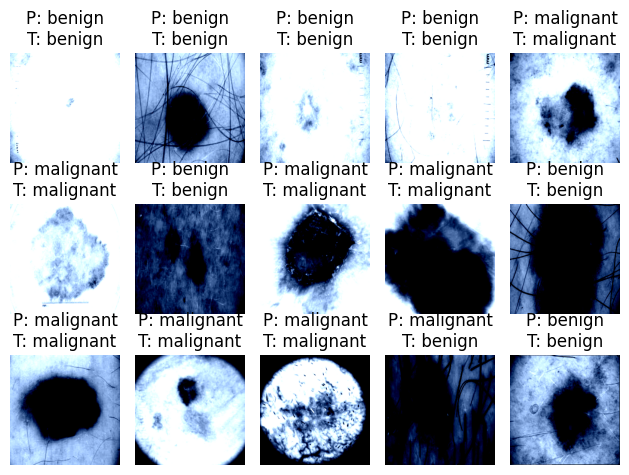

In [ ]:
data_module = DataModule(64, 2, train_path)
data_module.setup()
test_dataloader = data_module.test_dataloader()
show_examples(
    model=efficientnet, data_loader=test_dataloader, class_dict=class_dict
)

Khởi tạo và thiết lập DataModule:
- `data_module = DataModule(64, 2, train_path)` tạo một thể hiện của DataModule với batch size là 64, số lượng worker là 2, và đường dẫn đến dữ liệu huấn luyện là train_path.
- `data_module.setup()` được gọi để chuẩn bị và cấu hình dữ liệu cho quá trình huấn luyện, xác thực, và kiểm thử.

Lấy DataLoader cho tập kiểm thử và hiển thị các ví dụ:
- `test_dataloader = data_module.test_dataloader()` trả về DataLoader cho tập kiểm thử.
- `show_examples(model=efficientnet, data_loader=test_dataloader, class_dict=class_dict)` sử dụng hàm `show_examples` để hiển thị ảnh từ `test_dataloade`r cùng với dự đoán của mô hình `efficientnet` và tên lớp từ `class_dict`.
- Hàm này sẽ lấy một batch dữ liệu từ `test_dataloader`, sử dụng mô hình `efficientnet` để dự đoán, và sau đó hiển thị các hình ảnh cùng với nhãn dự đoán và nhãn thực tế.

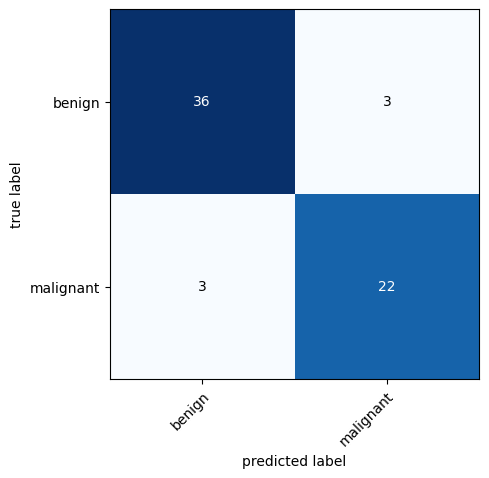

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_module = DataModule(64,1,train_path)
data_module.setup()
test_dataloader = data_module.test_dataloader()
model = efficientnet.to(device)
cmat = ConfusionMatrix(num_classes=len(class_dict),task='multiclass').to(device)

# for i in range(10):
targets = next(iter(test_dataloader))["labels"]
features = next(iter(test_dataloader))["images"]

with torch.no_grad():
    logits = model(features.to(device))
    pred = torch.argmax(logits, dim=1)
cmat(pred, targets.to(device))

cmat_tensor = cmat.compute()
cmat = cmat_tensor.cpu().numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
    # normed colormaps highlight the off-diagonals
    # for high-accuracy models better
)

plt.show()

Thiết lập môi trường dữ liệu và confusion matrix:
- `device` được thiết lập để sử dụng GPU nếu có sẵn, ngược lại sẽ sử dụng CPU.
- Tạo và thiết lập `DataModule` với batch size là 64, 1 worker, và đường dẫn đến dữ liệu huấn luyện.
- `test_dataloader` chứa dữ liệu kiểm thử.
- `model = efficientnet.to(device)` chuyển mô hình `efficientnet` sang GPU hoặc CPU tùy thuộc vào thiết bị được chọn.
- `cmat` là thể hiện của `ConfusionMatrix` từ thư viện `torchmetrics`, dùng để tính toán confusion matrix.

Tính toán confusion matrix:
- Lấy một batch dữ liệu từ `test_dataloader` và thực hiện dự đoán.
- `with torch.no_grad():` đảm bảo không tính toán gradient trong quá trình này.
- `logits = model(features.to(device)):` Dự đoán từ mô hình.
- `pred = torch.argmax(logits, dim=1):` Chuyển logits thành chỉ số lớp dự đoán.
- `cmat(pred, targets.to(device)):` Cập nhật ma trận nhầm lẫn với dự đoán và nhãn thực tế.

Hiển thị confusion matrix:
- `cmat_tensor = cmat.compute()` tính toán kết quả cuối cùng của ma trận nhầm lẫn.
- Chuyển ma trận về dạng NumPy array và sử dụng `plot_confusion_matrix` để hiển thị.
-` class_names=class_dict.values()` cung cấp tên của các lớp.
- `norm_colormap=matplotlib.colors.LogNorm()` sử dụng colormap được chuẩn hóa logarit để làm nổi bật các giá trị nằm ngoài đường chéo chính, hữu ích cho mô hình có độ chính xác cao.

**Nhận xét kết quả**:
Confusion matrix hiển thị mô hình phân loại hiệu quả giữa các lớp `benign` và `malignant`, với 36 dự đoán chính xác cho `benign` và 22 cho `malignant`. Có 3 trường hợp nhầm lẫn cho mỗi lớp, cho thấy mô hình có vài lỗi nhỏ nhưng vẫn có hiệu suất tốt.

# 6. Conclusion

Trong quá trình phát triển các mô hình cho tác vụ Skin Scanner Classification, chúng ta đã thực hiện một loạt các bước cần thiết từ nhập dữ liệu và thư viện, chuẩn bị dữ liệu, xây dựng module dữ liệu, đến huấn luyện và kiểm thử các mô hình. Điều này bao gồm việc triển khai và đánh giá ba kiến trúc mạng neural phổ biến: MobileNet V3 Large, EfficientNet B3, và một mô hình Ensemble sử dụng phương pháp Stacking.

Từ kết quả thu được, chúng ta nhận thấy rằng mỗi mô hình có những điểm mạnh riêng biệt. MobileNet V3 Large nổi bật với khả năng tính toán nhanh và hiệu quả, phù hợp với các ứng dụng cần phản hồi thời gian thực hoặc thiết bị có tài nguyên hạn chế. Mặt khác, EfficientNet B3 đã cho thấy được khả năng phân loại xuất sắc với độ chính xác cao nhất trong số các mô hình được thử nghiệm, làm nổi bật tiềm năng ứng dụng của nó trong các tình huống đòi hỏi độ chính xác cực kỳ cao. Mô hình Ensemble đã không thể vượt qua hiệu suất của EfficientNet B3 trong thử nghiệm, nhưng vẫn là một cách tiếp cận quan trọng để cải thiện độ ổn định và giảm variance trong dự đoán. Điều này cho thấy rằng việc tích hợp các mô hình khác nhau có thể cung cấp một lớp bảo vệ bổ sung chống lại dữ liệu nhiễu và có thể hữu ích trong các hệ thống sản xuất phức tạp.

Việc so sánh giữa các mô hình cung cấp cho chúng ta cái nhìn sâu sắc về cách chọn mô hình phù hợp với yêu cầu cụ thể của mỗi ứng dụng. Điều quan trọng là phải cân nhắc không chỉ đến hiệu suất mô hình, mà còn cả đến các yếu tố như chi phí tính toán, dễ dàng triển khai, và phù hợp với mục tiêu kinh doanh hoặc nghiên cứu.

Trong quá trình đánh giá, chúng ta đã sử dụng các phương pháp như ma trận nhầm lẫn và hiển thị ví dụ cụ thể để hiểu rõ hơn về hành vi của các mô hình. Điều này không chỉ giúp xác định được mô hình nào hoạt động tốt nhất, mà còn cung cấp cái nhìn sâu sắc về cách các mô hình đưa ra quyết định của mình.

Kết luận, phát triển này củng cố quan điểm rằng không có một giải pháp duy nhất cho mọi vấn đề trong học máy, và việc chọn mô hình phù hợp đòi hỏi phải xem xét đến một loạt các yếu tố khác nhau. Trong tương lai, việc tiếp tục thử nghiệm và tinh chỉnh các mô hình sẽ là chìa khóa để đạt được những cải tiến đáng kể và đáp ứng các yêu cầu ngày càng tăng trong lĩnh vực học sâu.